In [2]:
import pandas as pd
import numpy as np
import statistics as stats

# sklearn utility
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import export_text

# sklearn grid search
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score

import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("base_chess_data.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...


In [4]:
# add number of moves to each game

game_num_moves = []

for index, row in df.iterrows():
    num_moves_by_both = len(row['Moves'].split(" "))
    num_white_moves = (num_moves_by_both // 2) + (num_moves_by_both % 2 == 1)
    game_num_moves.append(num_white_moves)


df['NumWhiteMoves'] = game_num_moves
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55,7
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25


In [5]:
# There are many games where the only move made was the first one, and then the match was cancelled.
# We still want to remove those.

list_to_remove = []
for index, row in df.iterrows():
    if(len(row['Moves'].split(" ")) <= 2):
        list_to_remove.append(index)

df = df.drop(list_to_remove)



In [6]:
# add column for all deltas

# For moves with NA, we assume they have 0 change in the current board strength.

deltas = []

for index, row in df.iterrows():
    
    boardStrengths = row["StockfishScores"].split(" ")
    
    delta_string = ""
    current_board_strength = 0

    for score in boardStrengths:
        if(score == "NA"):
            delta_string += "0 "
            continue
        
        try:
            numeric_score = int(score)
        except:
            print(row["Moves"])
        delta = numeric_score - current_board_strength
        delta_string += str(delta) + " "

        current_board_strength = numeric_score

    delta_string = delta_string[:-1] # remove trailing whitespace
    
    deltas.append(delta_string)


df['StockfishDeltas'] = deltas

df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19,18 -1 -5 -4 -13 17 -9 -5 24 -1 -1 -7 -5 13 -10...
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55,7,26 18 -18 -8 -4 20 2 -5 6 -2 7 10 3
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53,26 25 17 -11 8 12 -29 45 -32 2 0 -5 -5 -7 23 -...
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39,2 19 -16 48 -18 10 -8 17 -44 12 -14 40 -18 -13...
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25,26 38 -29 18 -35 2 -2 2 -10 39 11 35 -4 -9 1 1...


In [7]:
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19,18 -1 -5 -4 -13 17 -9 -5 24 -1 -1 -7 -5 13 -10...
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55,7,26 18 -18 -8 -4 20 2 -5 6 -2 7 10 3
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53,26 25 17 -11 8 12 -29 45 -32 2 0 -5 -5 -7 23 -...
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39,2 19 -16 48 -18 10 -8 17 -44 12 -14 40 -18 -13...
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25,26 38 -29 18 -35 2 -2 2 -10 39 11 35 -4 -9 1 1...


We want to stratify our train/test/validation sets based on the length of the games as well as whether white wins. So, we will create bins for the 'short,' 'medium', and 'long' games. The code will create 3 bins, and can be changed to create more bins.

In [8]:
df['numMovesBin'] = pd.qcut(df['NumWhiteMoves'], q=3, labels=[1,2,3])
df.head()
df['numMovesBin'].value_counts()

1    8487
2    8382
3    8103
Name: numMovesBin, dtype: int64

In [9]:
# stratify the data only based on whether white wins
x_train, x_temp, y_train, y_temp = train_test_split(df, df['WhiteWins'], test_size=0.2, random_state=45, stratify=df[['WhiteWins', 'numMovesBin']])
x_train = x_train.drop('WhiteWins', axis=1)
x_temp = x_temp.drop('WhiteWins', axis=1)
x_train.head()

,WhiteElo,BlackElo,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas,numMovesBin
18383,2401,2001,Nf3 Nf6 c4 c5 Nc3 d6 g3 g6 Bg2 Bg7 d4 cxd4 Nxd...,18 17 12 8 22 46 0 7 21 24 32 34 39 41 39 33 3...,24,18 -1 -5 -4 14 24 -46 7 14 3 8 2 5 2 -2 -6 6 -...,1
11894,1939,2473,d4 g6 Nf3 Bg7 c4 Nf6 Nc3 d5 cxd5 Nxd5 e4 Nxc3 ...,19 77 51 74 53 46 33 65 50 51 52 54 36 47 41 2...,60,19 58 -26 23 -21 -7 -13 32 -15 1 1 2 -18 11 -6...,3
3851,2415,2303,e4 c5 Nf3 d6 c3 Nf6 h3 Nc6 Bd3 d5 e5 Nd7 Bb5 e...,26 64 35 53 18 13 2 -23 -17 -15 -11 -30 -23 -2...,70,26 38 -29 18 -35 -5 -11 -25 6 2 4 -19 7 3 1 -1...,3
24090,2329,2249,e4 e5 d4 exd4 c3 d5 exd5 Qxd5 cxd4 Qe4+ Be3 Nf...,26 45 8 21 -12 -21 -7 9 2 50 41 66 51 37 72 65...,62,26 19 -37 13 -33 -9 14 16 -7 48 -9 25 -15 -14 ...,3
15670,1885,1930,e4 c5 Nf3 e6 d4 cxd4 Nxd4 Nf6 Nc3 d6 Bg5 Be7 Q...,26 64 35 42 38 38 22 33 17 31 20 22 13 4 2 11 ...,18,26 38 -29 7 -4 0 -16 11 -16 14 -11 2 -9 -9 -2 ...,1


In [10]:
type(y_train)
y_train

18383    2
11894    0
3851     2
24090    1
15670    0
        ..
20592    1
20293    2
19410    2
20007    2
17932    2
Name: WhiteWins, Length: 19977, dtype: int64

In [11]:
# create a validation set

x_valid, x_test, y_valid, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=45, stratify=y_train)
x_train.shape[0], x_valid.shape[0], x_train.shape[0]

(19977, 15981, 19977)

## New Dataframe: Row For Each Move

Now that we have training/test/validation sets per game, we will create new dataframes based on the row for each move. For example, a game that lasts 30 games will have 30 rows, each of which will have information of its game up to the Nth move. We will add a column for them to also include their current move.

NOTE THAT some of the moves from stockfish, from this example, have "NA" as their stockfish score, because the computation would have taken too long. In these instances, we decide to use the previous move's data.

In [ ]:
# TODO
# TODO Figure out the specifics of stockfish: whether we decide the early-drawed games are the same as actual draws or bad data,
# TODO

In [13]:
from buildChessDFPerMove import buildChessDataframePerMove

x_trainPerMove, y_trainPerMove = buildChessDataframePerMove(x_train, y_train)
x_testPerMove, y_testPerMove = buildChessDataframePerMove(x_test, y_test)
x_validPerMove, y_validPerMove = buildChessDataframePerMove(x_valid, y_valid)

After creating a row for each of our 25000 games, our training set (containing 18000 of these games) has 1316297 rows.

In [14]:
x_trainPerMove.head()

,,WhiteElo,BlackElo,EloDifference,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta,MoveNum*StockfishScore,MoveNum*WhiteAvgDelta,MoveNum*BlackAvgDelta
,GameId,,,,,,,,,,,
0,18383,2401,2001,400,1,1,18,18.0,0.0,18,18.0,0.0
1,18383,2401,2001,400,2,0,17,18.0,-1.0,34,36.0,-2.0
2,18383,2401,2001,400,3,1,12,6.5,-1.0,36,19.5,-3.0
3,18383,2401,2001,400,4,0,8,6.5,-2.5,32,26.0,-10.0
4,18383,2401,2001,400,5,1,22,9.0,-2.5,110,45.0,-12.5


In [15]:
x_train

,WhiteElo,BlackElo,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas,numMovesBin
18383,2401,2001,Nf3 Nf6 c4 c5 Nc3 d6 g3 g6 Bg2 Bg7 d4 cxd4 Nxd...,18 17 12 8 22 46 0 7 21 24 32 34 39 41 39 33 3...,24,18 -1 -5 -4 14 24 -46 7 14 3 8 2 5 2 -2 -6 6 -...,1
11894,1939,2473,d4 g6 Nf3 Bg7 c4 Nf6 Nc3 d5 cxd5 Nxd5 e4 Nxc3 ...,19 77 51 74 53 46 33 65 50 51 52 54 36 47 41 2...,60,19 58 -26 23 -21 -7 -13 32 -15 1 1 2 -18 11 -6...,3
3851,2415,2303,e4 c5 Nf3 d6 c3 Nf6 h3 Nc6 Bd3 d5 e5 Nd7 Bb5 e...,26 64 35 53 18 13 2 -23 -17 -15 -11 -30 -23 -2...,70,26 38 -29 18 -35 -5 -11 -25 6 2 4 -19 7 3 1 -1...,3
24090,2329,2249,e4 e5 d4 exd4 c3 d5 exd5 Qxd5 cxd4 Qe4+ Be3 Nf...,26 45 8 21 -12 -21 -7 9 2 50 41 66 51 37 72 65...,62,26 19 -37 13 -33 -9 14 16 -7 48 -9 25 -15 -14 ...,3
15670,1885,1930,e4 c5 Nf3 e6 d4 cxd4 Nxd4 Nf6 Nc3 d6 Bg5 Be7 Q...,26 64 35 42 38 38 22 33 17 31 20 22 13 4 2 11 ...,18,26 38 -29 7 -4 0 -16 11 -16 14 -11 2 -9 -9 -2 ...,1
...,...,...,...,...,...,...,...
20592,2133,2481,d4 d5 c4 c6 cxd5 cxd5 Bf4 Nf6 Nc3 a6 e3 Nc6 Nf...,19 13 9 34 20 22 22 29 41 32 39 35 31 35 19 24...,89,19 -6 -4 25 -14 2 0 7 12 -9 7 -4 -4 4 -16 5 -5...,3
20293,2361,2143,Nf3 Nf6 c4 e6 g3 b6 Bg2 Bb7 O-O Be7 Re1 O-O Nc...,21 17 12 17 -4 16 17 14 9 15 5 6 6 24 22 41 40...,42,21 -4 -5 5 -21 20 1 -3 -5 6 -10 1 0 18 -2 19 -...,2
19410,2271,1307,e4 c5 Nf3 e6 c3 a6 d4 Qc7 Bd3 d6 O-O Nd7 Qe2 N...,26 64 42 48 13 64 39 94 82 86 87 88 81 65 75 7...,25,26 38 -22 6 -35 51 -25 55 -12 4 1 1 -7 -16 10 ...,1
20007,2643,2556,d4 Nf6 c4 c5 d5 e6 Nc3 exd5 cxd5 d6 e4 g6 f4 B...,19 17 22 50 51 48 54 63 50 45 59 95 88 58 62 5...,39,19 -2 5 28 1 -3 6 9 -13 -5 14 36 -7 -30 4 -12 ...,2


In [16]:
x_train.describe()

,WhiteElo,BlackElo,NumWhiteMoves
count,19977.000000,19977.000000,19977.000000
mean,2247.701206,2243.184112,41.442509
std,268.369459,270.856249,16.865980
min,1137.000000,1128.000000,2.000000
25%,2076.000000,2068.000000,30.000000
50%,2272.000000,2269.000000,40.000000
75%,2448.000000,2447.000000,51.000000
max,2864.000000,2881.000000,165.000000


C:\Users\stard\AppData\Local\Temp\ipykernel_4428\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

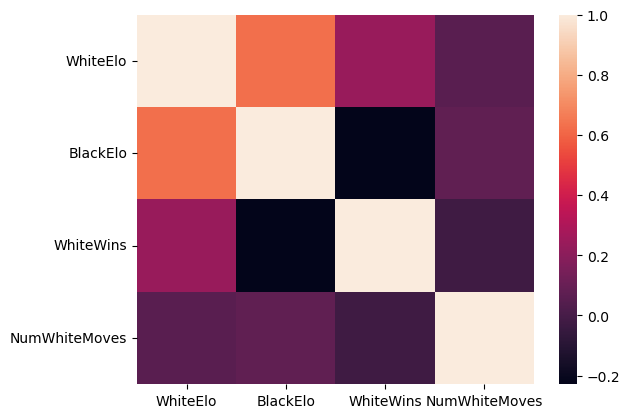

In [17]:
sns.heatmap(df.corr())

This correlation plot shows that there is a low correlation between the number of moves and whether white wins or how skilled either player is. However, a bigger elo difference has a considerable influence on whether white will win.

We also see an interesting correlation between black's elo and white's elo. Most elo matchmaking systems involve matching players of similar elo, in order to maximize the number of close games, and so this is likely attributed to that.

To ensure the strength of our model, we'll drop blackElo from the variables we examine.

# Building a Multinomial Logistic Model

We will create a multinomial logistic regression model to predict the win probability given a specific move.

This model will include the elo of white, the difference in elo, the current turn number, the stockfish difference, and average stockfish delta from white and black. We will also include interaction terms between the move number and the current stockfish score, white's average delta, and black's average delta, because of their perceived importance.

Afterwards, we will create a feature importance graph to see whether the selected variables are useful, and finally visualize how the win probability affects a given game. 

In [18]:
# scale our data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_trainPerMove)
x_valid_scaled = scaler.transform(x_validPerMove)
x_test_scaled = scaler.transform(x_testPerMove)

In [19]:
# build the logistic model
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg_model.fit(x_train_scaled, y_trainPerMove)

y_pred = logreg_model.predict(x_valid_scaled)

c:\Users\stard\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# logistic model metrics

# AUC Score. ROC curve is only used in binomial curves.
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

y_pred_proba = logreg_model.predict_proba(x_valid_scaled)
macro_roc_auc_ovr = roc_auc_score(
    y_validPerMove,
    y_pred_proba,
    multi_class="ovr",
    average="macro",
)
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.83


In [21]:
# logistic model feature importance
# from https://forecastegy.com/posts/feature-importance-in-logistic-regression/
def showFeatureImportance(logreg_model):
    '''
    Builds a feature importance chart from the variables from a logistic regression model.
    
    Parameters:
        logreg_model: the model to build the chart from
        
    Returns: None.
    '''
    coefficients = logreg_model.coef_

    avg_importance = np.mean(np.abs(coefficients), axis=0)
    feature_importance = pd.DataFrame({'Feature': x_trainPerMove.columns, 'Importance': avg_importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10,6))

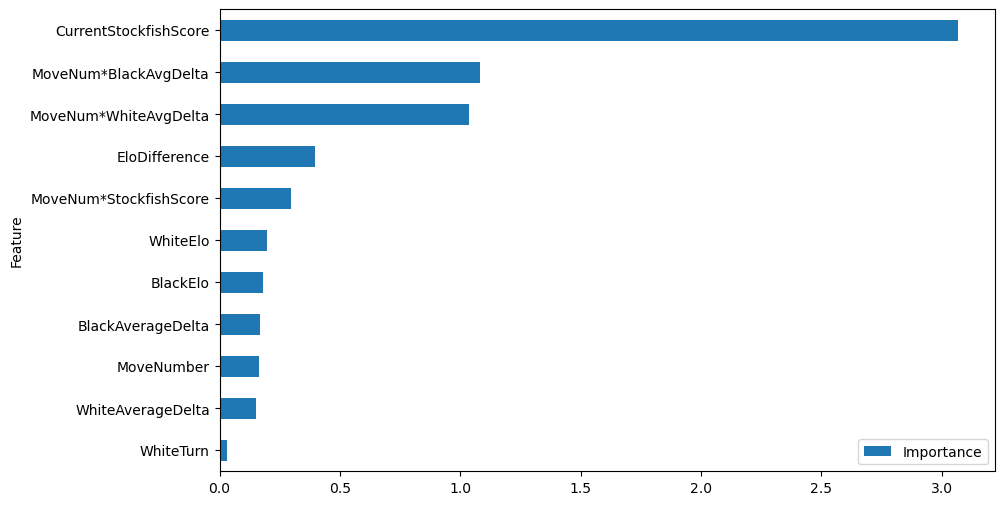

In [22]:
showFeatureImportance(logreg_model)

In [23]:
features = pd.DataFrame({'Feature': x_trainPerMove.columns, 'BlackImportance': logreg_model.coef_[0], 'TieImportance': logreg_model.coef_[1], 'WhiteImportance': logreg_model.coef_[2]})


In [24]:
features

,Feature,BlackImportance,TieImportance,WhiteImportance
0,WhiteElo,-0.293319,0.061352,0.231967
1,BlackElo,0.211634,0.061247,-0.272881
2,EloDifference,-0.595696,-0.000082,0.595778
3,MoveNumber,-0.104500,0.248589,-0.144089
4,WhiteTurn,-0.042901,-0.001051,0.043952
5,CurrentStockfishScore,-4.314031,-0.284503,4.598534
6,WhiteAverageDelta,0.011539,0.215266,-0.226805
7,BlackAverageDelta,0.253000,-0.085551,-0.167448
8,MoveNum*StockfishScore,0.270830,0.176764,-0.447594
9,MoveNum*WhiteAvgDelta,-1.390789,-0.162773,1.553561


In [25]:
# visualize model
def buildStackedLinearWPPlot(dataframe, game_id, model, scaler):
    '''
    Creates a stacked linear plot of predicted win probabilities using a win probability model.
    
    Parameters:
    - dataframe: the pandas dataframe (non-scaled) with all the data. 
    - game_id: the id of the game to be used (integer).
    - model: Some subtype of Classifier. Must have a predict_proba() function to use on the dataframe.

    - scaler: how the data is scaled before using the model.
    '''

    df_to_predict = dataframe.loc[pd.IndexSlice[:, game_id], :]
    scaled_df_to_predict = scaler.transform(df_to_predict)

    #print(scaled_df_to_predict.head())
    probabilities = model.predict_proba(scaled_df_to_predict)

    move_numbers = df_to_predict.loc[:,'MoveNumber'].values
    black_probas = probabilities[:,0]
    tie_probas = probabilities[:,1]
    white_probas = probabilities[:,2]
    #print(probabilities)


    sns.set_theme(palette=None)
    color_map = ['#333', '#777', '#ccc']
    plt.stackplot(move_numbers, 
                  black_probas, 
                  tie_probas, 
                  white_probas, 
                  colors=color_map, 
                  labels=['Black', 'Draw', 'White'],)

    plt.xlabel('Move Number')
    plt.ylabel('Win Probability')
    plt.legend(loc='upper left')
    #plt.stackplot(df.x, df.y1, df.y2, df.y3)

    return

In [26]:
x_validPerMove

,,WhiteElo,BlackElo,EloDifference,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta,MoveNum*StockfishScore,MoveNum*WhiteAvgDelta,MoveNum*BlackAvgDelta
,GameId,,,,,,,,,,,
0,16404,2061,1865,196,1,1,26,26.000000,0.000000,26,26.000000,0.000000
1,16404,2061,1865,196,2,0,44,26.000000,18.000000,88,52.000000,36.000000
2,16404,2061,1865,196,3,1,26,4.000000,18.000000,78,12.000000,54.000000
3,16404,2061,1865,196,4,0,14,4.000000,3.000000,56,16.000000,12.000000
4,16404,2061,1865,196,5,1,19,4.333333,3.000000,95,21.666667,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1316292,14898,2815,2771,44,105,1,320,-4.698113,10.942308,33600,-493.301887,1148.942308
1316293,14898,2815,2771,44,106,0,301,-4.698113,10.377358,31906,-498.000000,1100.000000
1316294,14898,2815,2771,44,107,1,331,-4.055556,10.377358,35417,-433.944444,1110.377358


In [27]:
print(x_valid.head())
print(y_valid.head())

       WhiteElo  BlackElo                                              Moves  \
16404      2061      1865  e4 e5 Nf3 Nc6 Bc4 Bc5 c3 Nf6 d3 a6 Bb3 Ba7 O-O...   
12749      2408      2340  d4 Nf6 c4 e6 Nf3 Bb4+ Bd2 Qe7 Bc3 b6 a3 Bxc3+ ...   
16361      2323      2415  e4 d5 e5 Bf5 d4 e6 c3 c5 f4 Nc6 Nf3 h5 Bd3 Nh6...   
21658      2264      2078  Nf3 Nf6 d4 g6 Bg5 Bg7 Nbd2 d5 e3 O-O c4 c5 dxc...   
9083       2039      2273  e4 e6 d4 d5 Nc3 Nf6 e5 Nfd7 Nf3 c5 dxc5 Nc6 Bf...   

                                         StockfishScores  NumWhiteMoves  \
16404  26 44 26 14 19 53 22 9 6 29 0 13 12 22 14 18 1...             48   
12749  19 17 22 22 28 33 30 63 35 32 26 32 29 24 5 24...             38   
16361  26 51 7 22 24 24 -3 5 -57 -64 -73 -18 -54 -50 ...             42   
21658  15 17 8 48 36 21 34 15 31 24 -1 17 -13 41 67 5...             24   
9083   26 42 43 29 31 22 12 0 -3 0 -33 -2 -32 -34 -29...             49   

                                         StockfishDeltas numMovesBin

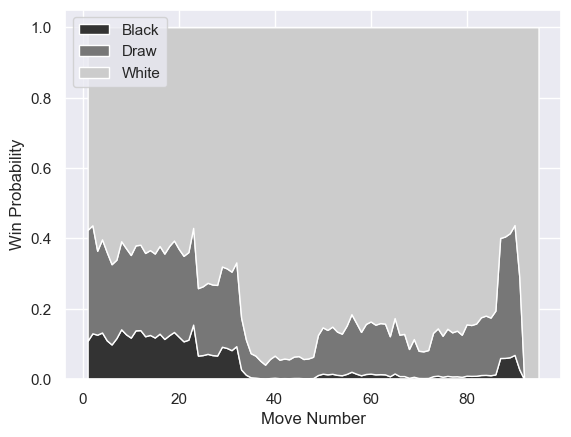

In [28]:
buildStackedLinearWPPlot(x_validPerMove, 16404, logreg_model, scaler) # white won

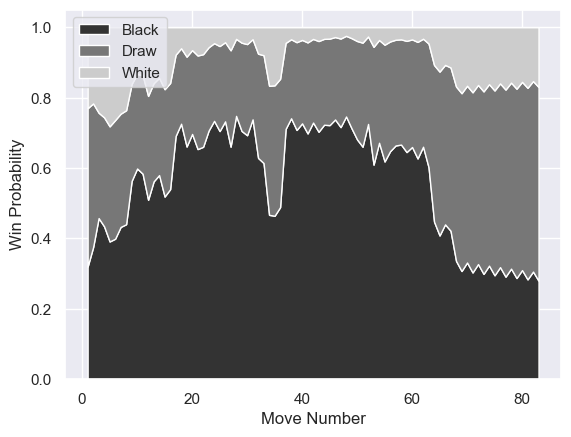

In [29]:
buildStackedLinearWPPlot(x_validPerMove, 16361, logreg_model, scaler) # draw

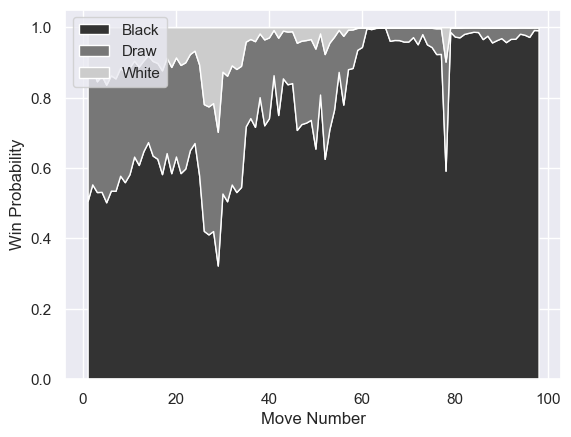

In [30]:
buildStackedLinearWPPlot(x_validPerMove, 9083, logreg_model, scaler) # black won

## Improving the Logistic Model

The above models illustrate an interesting problem with our data so far, where we have decently good accuracy as we get closer to the end of the game, but near the beginning of the game we're getting unexpected results. In particular, the elo difference between white and black does not seem to give as much of a pull as we were expecting.

So, we will build multiple alternative logistic regression models to find some balance between correctly predicting the endgame, and having a more consistent guess for the early game (white winning if elo is tied, otherwise whoever has a much higher elo.)

In [31]:
x_trainPerMove.head()

,,WhiteElo,BlackElo,EloDifference,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta,MoveNum*StockfishScore,MoveNum*WhiteAvgDelta,MoveNum*BlackAvgDelta
,GameId,,,,,,,,,,,
0,18383,2401,2001,400,1,1,18,18.0,0.0,18,18.0,0.0
1,18383,2401,2001,400,2,0,17,18.0,-1.0,34,36.0,-2.0
2,18383,2401,2001,400,3,1,12,6.5,-1.0,36,19.5,-3.0
3,18383,2401,2001,400,4,0,8,6.5,-2.5,32,26.0,-10.0
4,18383,2401,2001,400,5,1,22,9.0,-2.5,110,45.0,-12.5


In [32]:
# trying an alternative with no interactions and some additional deletions.

train_noMoveNumberInteractions = x_trainPerMove.drop(['BlackElo', 
                                           'WhiteTurn', 'MoveNum*StockfishScore',
                                           'MoveNum*WhiteAvgDelta',
                                           'MoveNum*BlackAvgDelta'
                                           ], axis=1)

valid_noMoveNumberInteractions = x_validPerMove.drop(['BlackElo',
                                           'WhiteTurn', 'MoveNum*StockfishScore',
                                           'MoveNum*WhiteAvgDelta',
                                           'MoveNum*BlackAvgDelta'
                                           ], axis=1)

scaler2 = StandardScaler()
x_train_noMove_scaled = scaler2.fit_transform(train_noMoveNumberInteractions)
x_valid_noMove_scaled = scaler2.transform(valid_noMoveNumberInteractions)

logreg_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg_model2.fit(x_train_noMove_scaled, y_trainPerMove)

y_pred = logreg_model2.predict(x_valid_noMove_scaled)

y_pred_proba = logreg_model2.predict_proba(x_valid_noMove_scaled)
macro_roc_auc_ovr = roc_auc_score(
    y_validPerMove,
    y_pred_proba,
    multi_class="ovr",
    average="macro",
)
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.83


Interestingly, only having the stockfish score and the elo difference still has an AUC score of 0.82 - 0.01 less than the original model. Let's see how it functions for a given game:

In [33]:
valid_noMoveNumberInteractions.index.unique(level='GameId')

Int64Index([16404, 12749, 16361, 21658,  9083,  5313, 22270,  5589, 24089,
             9986,
            ...
             8025,  8952,  8519, 15304,  4664,  5706, 24395, 24645, 10162,
            14898],
           dtype='int64', name='GameId', length=15981)

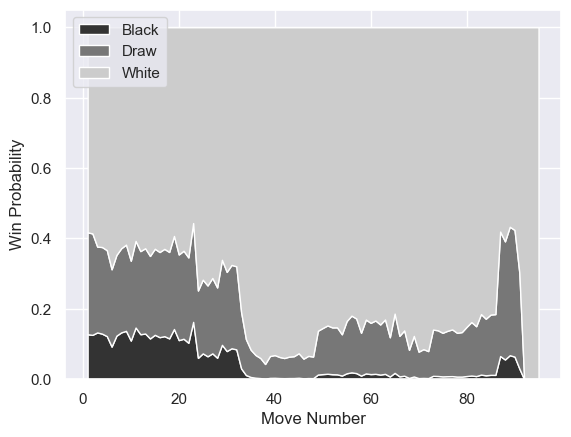

In [34]:
buildStackedLinearWPPlot(valid_noMoveNumberInteractions, 16404, logreg_model2, scaler2) # white won

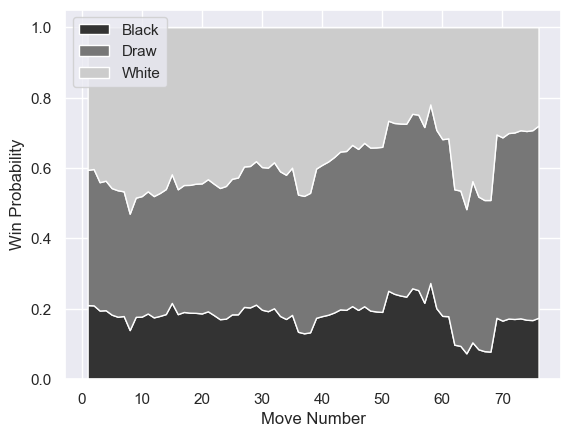

In [35]:
buildStackedLinearWPPlot(valid_noMoveNumberInteractions, 12749, logreg_model2, scaler2) # white won

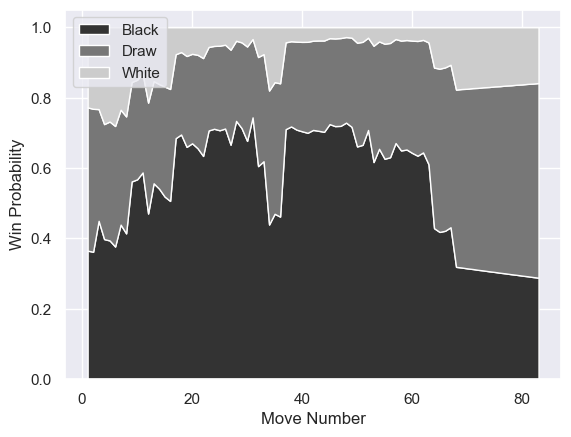

In [36]:
buildStackedLinearWPPlot(valid_noMoveNumberInteractions, 16361, logreg_model2, scaler2) # draw

Comparatively, this model is much cleaner for the win probabilities. It seems to trade certainty in the late game for more consistency in the early game.

## Adding Move Number Interactions with Stockfish Score

We saw a linear interaction between move number and stockfish score wasn't helpful, but perhaps it would grow in benefit the later we are in the model. In other words, we want a moveNumber^2*stockfishScore value.

In [37]:
# trying an alternative with no interactions and some additional deletions.

train_MoveNumberInteractions = x_trainPerMove.drop(['BlackElo', 
                                           'WhiteTurn',
                                           'MoveNum*WhiteAvgDelta',
                                           'MoveNum*BlackAvgDelta'
                                           ], axis=1)

valid_MoveNumberInteractions = x_validPerMove.drop(['BlackElo',
                                           'WhiteTurn',
                                           'MoveNum*WhiteAvgDelta',
                                           'MoveNum*BlackAvgDelta'
                                           ], axis=1)

train_MoveNumberInteractions['MoveNum^2*StockfishScore'] = (train_MoveNumberInteractions['MoveNum*StockfishScore']
                                                              * train_MoveNumberInteractions['MoveNumber'])

valid_MoveNumberInteractions['MoveNum^2*StockfishScore'] = (valid_MoveNumberInteractions['MoveNum*StockfishScore']
                                                              * valid_MoveNumberInteractions['MoveNumber'])


scaler3 = StandardScaler()
x_train_moveInter_scaled = scaler3.fit_transform(train_MoveNumberInteractions)
x_valid_moveInter_scaled = scaler3.transform(valid_MoveNumberInteractions)

logreg_model3 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
logreg_model3.fit(x_train_moveInter_scaled, y_trainPerMove)

y_pred = logreg_model3.predict(x_valid_moveInter_scaled)

y_pred_proba = logreg_model3.predict_proba(x_valid_moveInter_scaled)
macro_roc_auc_ovr = roc_auc_score(
    y_validPerMove,
    y_pred_proba,
    multi_class="ovr",
    average="macro",
)
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.83


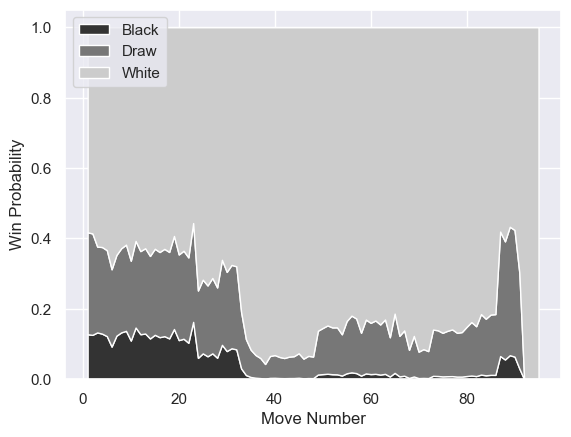

In [38]:
buildStackedLinearWPPlot(valid_noMoveNumberInteractions, 16404, logreg_model2, scaler2) # white won

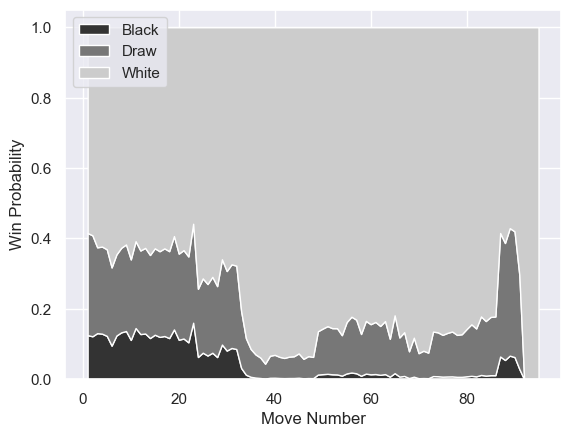

In [39]:
buildStackedLinearWPPlot(valid_MoveNumberInteractions, 16404, logreg_model3, scaler3) # white won

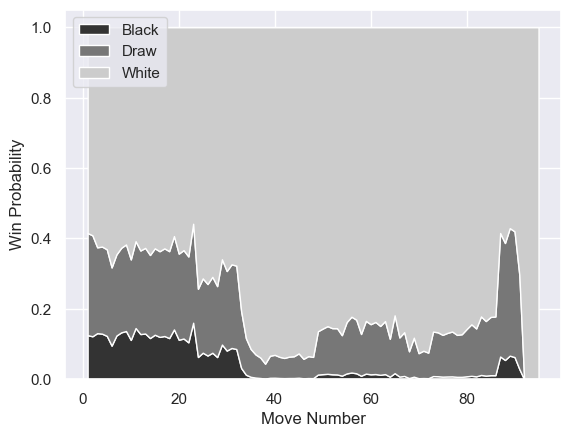

In [40]:
buildStackedLinearWPPlot(valid_MoveNumberInteractions, 16404, logreg_model3, scaler3) # white won

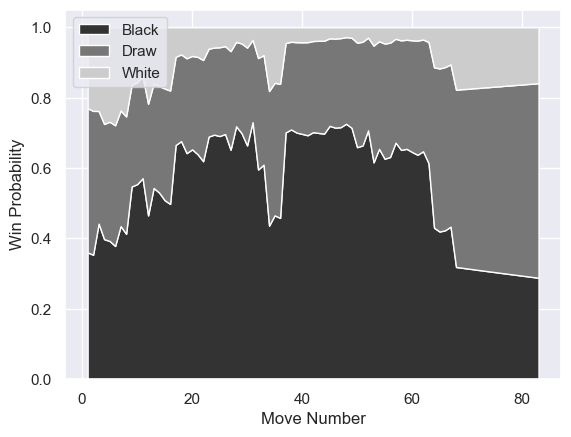

In [41]:
buildStackedLinearWPPlot(valid_MoveNumberInteractions, 16361, logreg_model3, scaler3) # draw

### Adding Move Number Interactions with WhiteAvgDelta

In [42]:
# trying an alternative with no interactions and some additional deletions.

train_MoveNumberInteraction4 = x_trainPerMove.drop(['BlackElo', 
                                           'WhiteTurn',
                                           'MoveNum*BlackAvgDelta'
                                           ], axis=1)

valid_MoveNumberInteraction4 = x_validPerMove.drop(['BlackElo',
                                           'WhiteTurn',
                                           'MoveNum*BlackAvgDelta'
                                           ], axis=1)

train_MoveNumberInteraction4['MoveNum^2*StockfishScore'] = (train_MoveNumberInteraction4['MoveNum*StockfishScore']
                                                              * train_MoveNumberInteraction4['MoveNumber'])

valid_MoveNumberInteraction4['MoveNum^2*StockfishScore'] = (valid_MoveNumberInteraction4['MoveNum*StockfishScore']
                                                              * valid_MoveNumberInteraction4['MoveNumber'])


scaler4 = StandardScaler()
x_train_moveInter_scaled = scaler4.fit_transform(train_MoveNumberInteraction4)
x_valid_moveInter_scaled = scaler4.transform(valid_MoveNumberInteraction4)

logreg_model4 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
logreg_model4.fit(x_train_moveInter_scaled, y_trainPerMove)

y_pred = logreg_model4.predict(x_valid_moveInter_scaled)

y_pred_proba = logreg_model4.predict_proba(x_valid_moveInter_scaled)
macro_roc_auc_ovr = roc_auc_score(
    y_validPerMove,
    y_pred_proba,
    multi_class="ovr",
    average="macro",
)
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.83


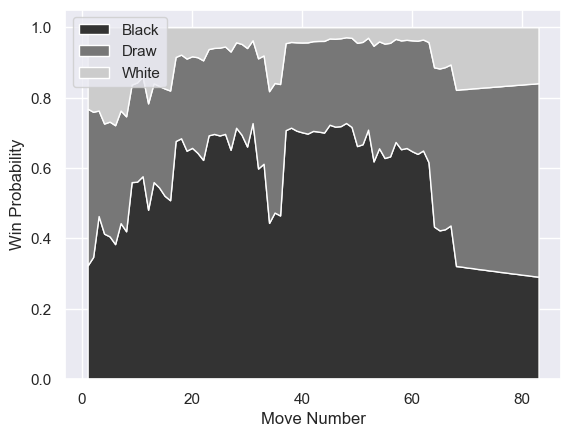

In [43]:
buildStackedLinearWPPlot(valid_MoveNumberInteraction4, 16361, logreg_model4, scaler4) # draw

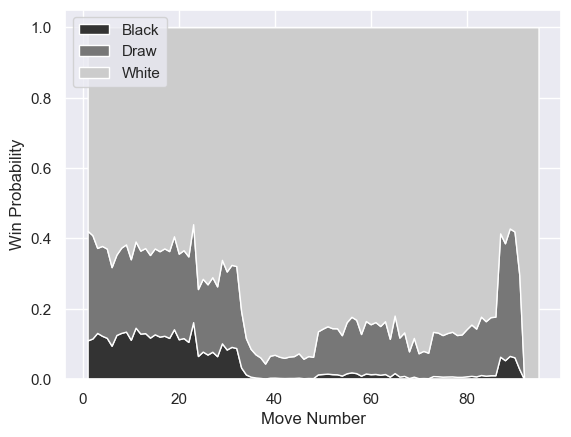

In [44]:
buildStackedLinearWPPlot(valid_MoveNumberInteraction4, 16404, logreg_model4, scaler4) # white wins

# Building an XGBoost Model

In [45]:
x_trainPerMove.head()

,,WhiteElo,BlackElo,EloDifference,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta,MoveNum*StockfishScore,MoveNum*WhiteAvgDelta,MoveNum*BlackAvgDelta
,GameId,,,,,,,,,,,
0,18383,2401,2001,400,1,1,18,18.0,0.0,18,18.0,0.0
1,18383,2401,2001,400,2,0,17,18.0,-1.0,34,36.0,-2.0
2,18383,2401,2001,400,3,1,12,6.5,-1.0,36,19.5,-3.0
3,18383,2401,2001,400,4,0,8,6.5,-2.5,32,26.0,-10.0
4,18383,2401,2001,400,5,1,22,9.0,-2.5,110,45.0,-12.5


In [46]:
# TODO: update the train, test, split to not 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_trainPerMove)
x_valid_scaled = scaler.transform(x_validPerMove)
x_test_scaled = scaler.transform(x_testPerMove)

Because of an XGBoost error (`ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]`), we have to change what WhiteWins represents. A 2 is white winning, a 1 is a tie, and a 0 is black winning.

In [47]:
gbm = xgb.XGBClassifier(random_state=42)
model = gbm.fit(x_train_scaled, y_trainPerMove,
                eval_set = [[x_train_scaled, y_trainPerMove],
                          [x_valid_scaled, y_validPerMove]]#,
               #eval_set = 'logloss',
                #early_stopping_rounds=10
                )

# was tests
xgb_valid_preds = model.predict(x_valid_scaled)
xgb_valid_proba = model.predict_proba(x_valid_scaled)

[0]	validation_0-mlogloss:0.96858	validation_1-mlogloss:0.96865
[1]	validation_0-mlogloss:0.89154	validation_1-mlogloss:0.89161
[2]	validation_0-mlogloss:0.84304	validation_1-mlogloss:0.84304
[3]	validation_0-mlogloss:0.81023	validation_1-mlogloss:0.81011
[4]	validation_0-mlogloss:0.78832	validation_1-mlogloss:0.78814
[5]	validation_0-mlogloss:0.77261	validation_1-mlogloss:0.77233
[6]	validation_0-mlogloss:0.76150	validation_1-mlogloss:0.76115
[7]	validation_0-mlogloss:0.75355	validation_1-mlogloss:0.75314
[8]	validation_0-mlogloss:0.74739	validation_1-mlogloss:0.74691
[9]	validation_0-mlogloss:0.74274	validation_1-mlogloss:0.74220
[10]	validation_0-mlogloss:0.73883	validation_1-mlogloss:0.73815
[11]	validation_0-mlogloss:0.73582	validation_1-mlogloss:0.73505
[12]	validation_0-mlogloss:0.73318	validation_1-mlogloss:0.73240
[13]	validation_0-mlogloss:0.73085	validation_1-mlogloss:0.73008
[14]	validation_0-mlogloss:0.72884	validation_1-mlogloss:0.72802
[15]	validation_0-mlogloss:0.72659	

In [48]:
xgb_valid_proba

array([[0.09468156, 0.25108287, 0.6542356 ],
       [0.10124369, 0.25749728, 0.6412591 ],
       [0.0971468 , 0.2630594 , 0.6397938 ],
       ...,
       [0.00285838, 0.05750783, 0.9396338 ],
       [0.00368846, 0.06884588, 0.9274657 ],
       [0.00257299, 0.03624961, 0.96117747]], dtype=float32)

In [49]:
x_validPerMove.head()

,,WhiteElo,BlackElo,EloDifference,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta,MoveNum*StockfishScore,MoveNum*WhiteAvgDelta,MoveNum*BlackAvgDelta
,GameId,,,,,,,,,,,
0,16404,2061,1865,196,1,1,26,26.000000,0.0,26,26.000000,0.0
1,16404,2061,1865,196,2,0,44,26.000000,18.0,88,52.000000,36.0
2,16404,2061,1865,196,3,1,26,4.000000,18.0,78,12.000000,54.0
3,16404,2061,1865,196,4,0,14,4.000000,3.0,56,16.000000,12.0
4,16404,2061,1865,196,5,1,19,4.333333,3.0,95,21.666667,15.0


In [50]:
# More multiindexing can be found at https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
# for example, getting all games with the same id of 14922.

x_validPerMove.loc[pd.IndexSlice[:, 16404], :].head()

,,WhiteElo,BlackElo,EloDifference,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta,MoveNum*StockfishScore,MoveNum*WhiteAvgDelta,MoveNum*BlackAvgDelta
,GameId,,,,,,,,,,,
0,16404,2061,1865,196,1,1,26,26.000000,0.0,26,26.000000,0.0
1,16404,2061,1865,196,2,0,44,26.000000,18.0,88,52.000000,36.0
2,16404,2061,1865,196,3,1,26,4.000000,18.0,78,12.000000,54.0
3,16404,2061,1865,196,4,0,14,4.000000,3.0,56,16.000000,12.0
4,16404,2061,1865,196,5,1,19,4.333333,3.0,95,21.666667,15.0


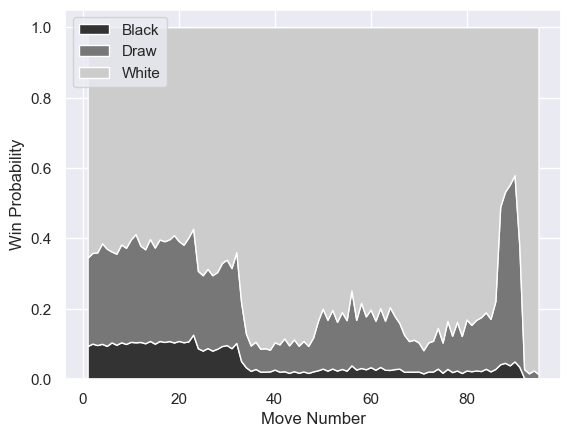

In [51]:
buildStackedLinearWPPlot(x_validPerMove, 16404, model, scaler)

- Maybe looking at white elo AND the white elo - black elo.
- interaction between move number and current stockfish score
- do you need interaction terms with xgboost

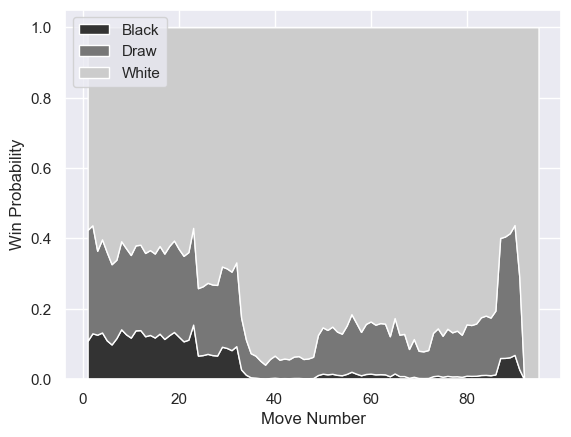

In [52]:
buildStackedLinearWPPlot(x_validPerMove, 16404, logreg_model, scaler)

In [53]:

logreg_model.coef_

array([[-2.93318586e-01,  2.11633951e-01, -5.95695951e-01,
        -1.04499884e-01, -4.29009383e-02, -4.31403107e+00,
         1.15387075e-02,  2.52999746e-01,  2.70830066e-01,
        -1.39078869e+00, -1.62478946e+00],
       [ 6.13520025e-02,  6.12467942e-02, -8.17227586e-05,
         2.48588917e-01, -1.05092063e-03, -2.84502649e-01,
         2.15266251e-01, -8.55514871e-02,  1.76764191e-01,
        -1.62772576e-01,  7.89282494e-03],
       [ 2.31966584e-01, -2.72880745e-01,  5.95777674e-01,
        -1.44089033e-01,  4.39518589e-02,  4.59853371e+00,
        -2.26804958e-01, -1.67448259e-01, -4.47594257e-01,
         1.55356126e+00,  1.61689664e+00]])

In [54]:
x_validPerMove.index.unique(level='GameId')
#y_validPerMove.head()

Int64Index([16404, 12749, 16361, 21658,  9083,  5313, 22270,  5589, 24089,
             9986,
            ...
             8025,  8952,  8519, 15304,  4664,  5706, 24395, 24645, 10162,
            14898],
           dtype='int64', name='GameId', length=15981)

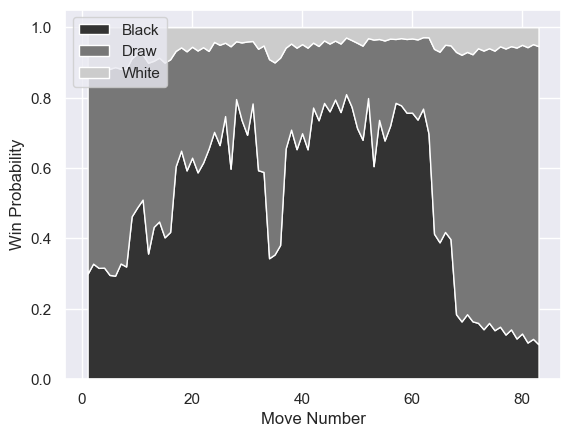

In [55]:
buildStackedLinearWPPlot(x_validPerMove, 16361, model, scaler)

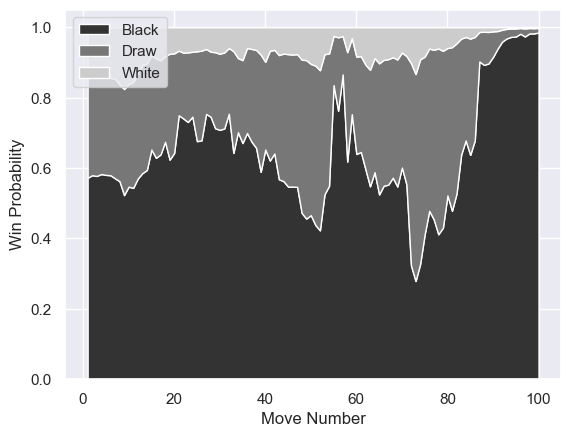

In [56]:
buildStackedLinearWPPlot(x_validPerMove, 5313, model, scaler)

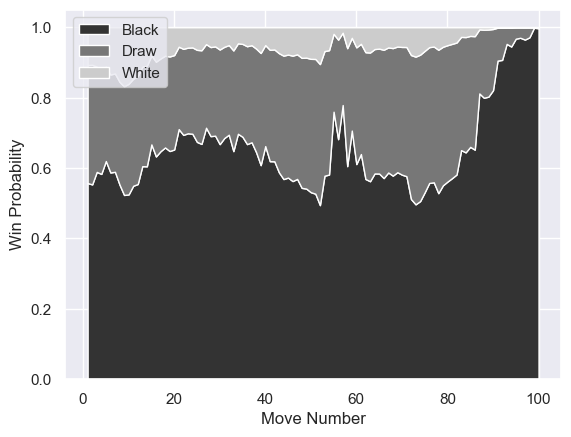

In [57]:
buildStackedLinearWPPlot(valid_MoveNumberInteraction4, 5313, logreg_model4, scaler4)

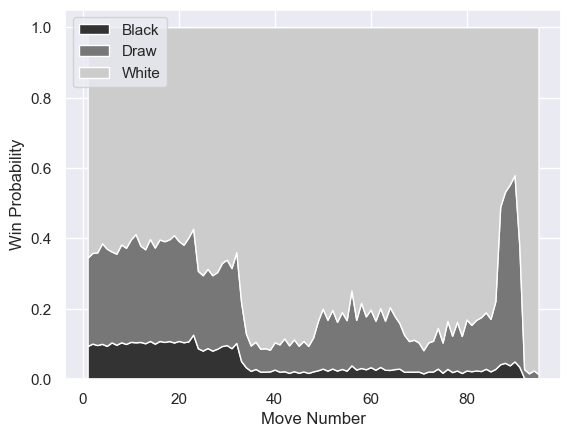

In [58]:
buildStackedLinearWPPlot(x_validPerMove, 16404, model, scaler)

# Visualizing the Change in Win Probability

Next, the goal is to find at what point our win probability changes the MOST. For example, in the previous graph there are two main "shifts" in the game: around move 37, where there's a massive increase in white's win probability, and then at the very end, where the tie probabillity plummets.

To do this, we want to look at the absolute .value of the change for white, black, and draw, and then choose the biggest one from those. We do this for every move in a graph.

In [59]:
def createWPChangeArray(dataframe, game_id, model, scaler):
    '''
    Creates a stacked linear plot of predicted win probabilities using a win probability model.
    
    Parameters:
    - dataframe: the pandas dataframe (non-scaled) with all the data. 
    - game_id: the id of the game to be used (integer).
    - model: Some subtype of Classifier. Must have a predict_proba() function to use on the dataframe.

    - scaler: how the data is scaled before using the model.
    '''

    df_to_predict = dataframe.loc[pd.IndexSlice[:, game_id], :]
    scaled_df_to_predict = scaler.transform(df_to_predict)

    #print(scaled_df_to_predict.head())
    probabilities = model.predict_proba(scaled_df_to_predict)

    wp_change_array = []

    wp_change_array.append(0)

    black_curr_proba = probabilities[0][0] 
    draw_curr_proba = probabilities[0][1]
    white_curr_proba = probabilities[0][2]

    for row in probabilities[1:]: # skip first probability row
        max_change = max(abs(row[0] - black_curr_proba), abs(row[1] - draw_curr_proba), abs(row[2] - draw_curr_proba))

        wp_change_array.append(max_change)
        black_curr_proba = row[0] 
        draw_curr_proba = row[1]
        white_curr_proba = row[2]

    return wp_change_array


Text(0.5, 1.0, 'Spikes in Win Probability for Game 16404')

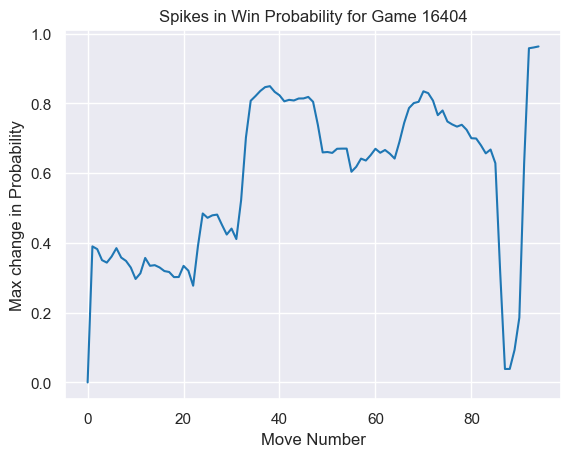

In [75]:
sns.lineplot(createWPChangeArray(x_validPerMove, 16404, model, scaler))
plt.xlabel("Move Number")
plt.ylabel("Max change in Probability")
plt.title("Spikes in Win Probability for Game 16404")

Next, we want a function to show the distribution in max changes. In other words, we want to aggregate how this changes for EVERY game in a dataset, and then ask ourselves "where does the win probability change the most over time? Are there any patterns with where it changes?" We'll do this in two ways. First, we will do it by taking the average over all of the wp arrays we create, and then we'll do the distribution of the maxes.

In [69]:
int(x_validPerMove.max(axis=0)['MoveNumber'])

329

In [ ]:
# this one's erroneous
def getProbabilityChangeAverages(dataframe, model, scaler):
    max_move_number = int(x_validPerMove.max(axis=0)['MoveNumber'])
    
    
    all_game_indices = dataframe.index.unique(level='GameId')

    total_change_distribution = list(0 for i in range(max_move_number))
    num_games_with_that_many = list(0 for i in range(max_move_number))

    for game_id in all_game_indices:
        curr_array = createWPChangeArray(dataframe, game_id, model, scaler)

        for move_number, winprob_change in enumerate(curr_array):
            num_games_with_that_many[move_number] += 1
            total_change_distribution[move_number] += winprob_change
        

    average_change_distribution = list((total_change_distribution[i] / num_games_with_that_many[i]) for i in range(max_move_number))

    return average_change_distribution


def buildWPMaxChangeAggregation(dataframe, model, scaler):
    '''

    '''
    max_move_number = int(x_validPerMove.max(axis=0)['MoveNumber'])

    all_game_indices = dataframe.index.unique(level='GameId')

    max_change_distribution = list(0 for i in range(max_move_number))

    for game_id in all_game_indices:
        curr_array = createWPChangeArray(dataframe, game_id, model, scaler)
        move_number_of_biggest_change = curr_array.index(max(curr_array))
        max_change_distribution[move_number_of_biggest_change] += 1

    return max_change_distribution



    


In [72]:
most_change_dist = buildWPMaxChangeAggregation(x_validPerMove, model, scaler)

In [82]:
average_change_per_move = getProbabilityChangeAverages(x_validPerMove, model, scaler)

Text(0.5, 1.0, 'Distribution of Points in Game where Max Change Occurred')

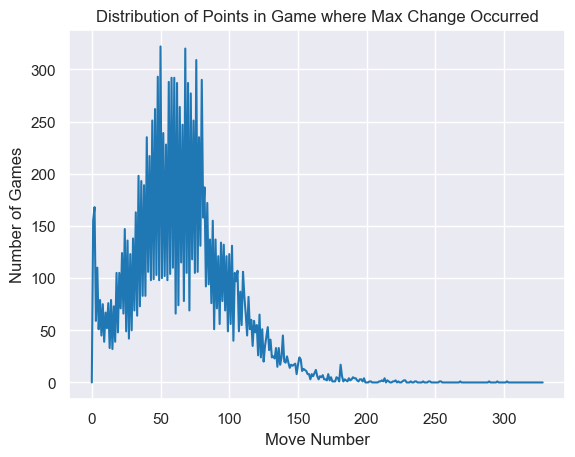

In [76]:
sns.lineplot(most_change_dist)
plt.xlabel("Move Number")
plt.ylabel("Number of Games")
plt.title("Distribution of Points in Game where Max Change Occurred")

In [79]:
print(average_change_per_move)

None


Text(0.5, 1.0, 'Distribution of Winprob Changing Throughout Games')

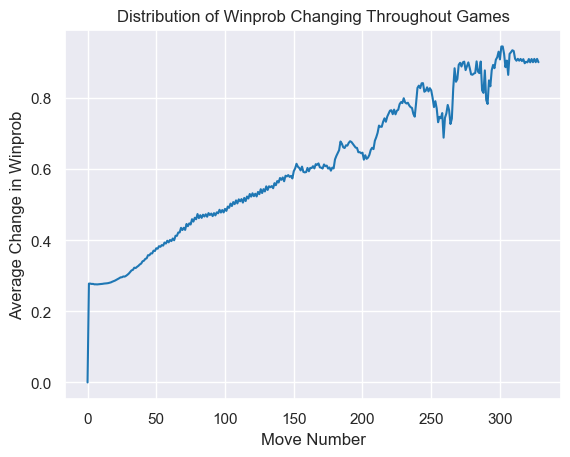

In [83]:
sns.lineplot(average_change_per_move)
plt.xlabel("Move Number")
plt.ylabel("Average Change in Winprob")
plt.title("Distribution of Winprob Changing Throughout Games")